In [19]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import itertools
import statsmodels.api as sm
from scipy.stats import norm
import seaborn as sns

sns.set_context('talk')
sns.set_style('dark')

import matplotlib.cm as cm
import theano.tensor as tt
import mat4py
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

### reading the data

In [20]:
# reference : https://archive.ics.uci.edu/ml/datasets/banknote+authentication#
df = pd.read_csv('data_banknote_authentication.txt', header = None)
df.drop_duplicates(inplace=True)
print (df.shape)
df.columns = ['image_variance', 'image_skewness', 'image_kurtosis', 'image_entropy', 'label']
df.head(3)

(1348, 5)


,image_variance,image_skewness,image_kurtosis,image_entropy,label
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0
2,3.8660,-2.6383,1.9242,0.10645,0


### train and test split

In [21]:
X = df.iloc[:, 0:-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((943, 4), (405, 4), (943,), (405,))

### data exploartion

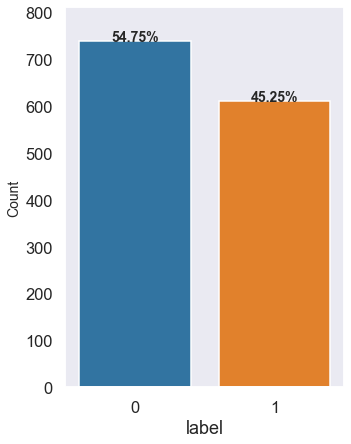

In [22]:
# reference: https://goldinlocks.github.io/Bayesian-logistic-regression-with-pymc3/
total = len(df)
plt.figure(figsize=(5, 7))
g = sns.countplot(x='label', data=df)
g.set_ylabel('Count', fontsize=14)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 1.5,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14, fontweight='bold')
plt.margins(y=0.1)
plt.savefig('plots/classes.png')
plt.show()

## bi-variate analysis

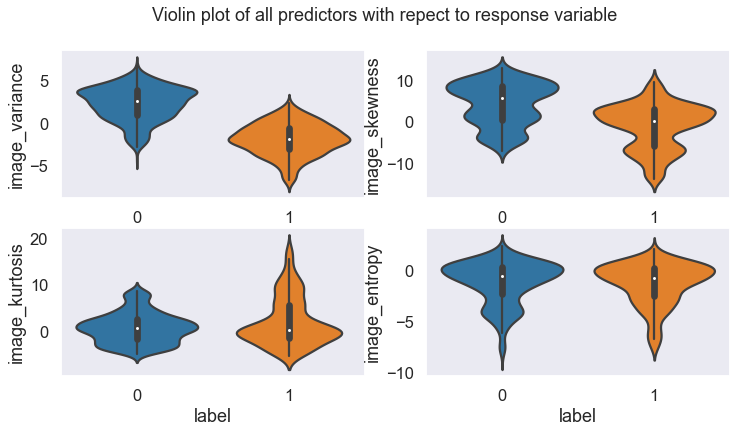

In [23]:
fig, axs = plt.subplots(ncols=2, nrows = 2, figsize=(12, 6))
plt.suptitle('Violin plot of all predictors with repect to response variable', size= 18)
sns.violinplot(x='label', y='image_variance', data=df, ax=axs[0, 0])
sns.violinplot(x='label', y='image_skewness', data=df, ax=axs[0, 1])
sns.violinplot(x='label',y='image_kurtosis', data=df, ax=axs[1, 0])
sns.violinplot(x='label',y='image_entropy', data=df, ax=axs[1, 1])
plt.savefig('plots/bi_variate.png')

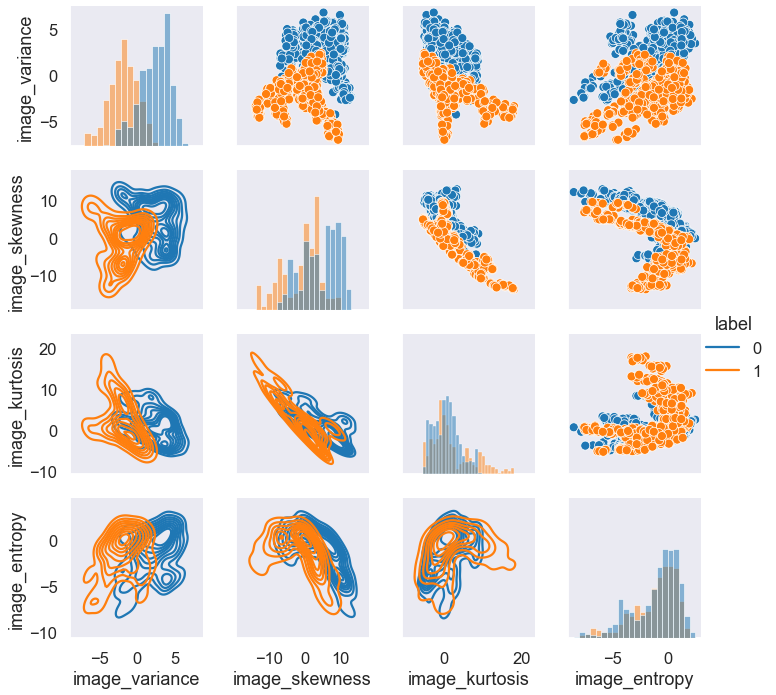

In [24]:
# pair plots
g = sns.PairGrid(df, hue="label")
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot)
g.add_legend()
plt.savefig('plots/pair_plot.png')

## fitting logistic regression model

In [25]:
logit_model = pm.Model()
burn_in = 1000
with logit_model:

    var_X = pm.Data('var', X_train[:,0])
    skew_X = pm.Data('skew', X_train[:,1])
    kurt_X = pm.Data('kurt', X_train[:,2])
    entropy_X = pm.Data('entropy', X_train[:,3])
    
    intercept = pm.Normal("intercept", mu=0, sigma=100)
    beta_var = pm.Normal("beta_var", mu=0, sigma=100)
    beta_skew = pm.Normal("beta_skew", mu=0, sigma=100)
    beta_kurt = pm.Normal("beta_kurt", mu=0, sigma=100)
    beta_entropy = pm.Normal("beta_entropy", mu=0, sigma=100)
    
    # Expected value of outcome
    p = pm.math.sigmoid(intercept + var_X * beta_var + skew_X * beta_skew + kurt_X * beta_kurt +
                        entropy_X * beta_entropy) # logit link

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli("Y_obs", p, observed= y_train)
    
with logit_model:

    step = pm.Slice()
    logit_trace = pm.sample(5000, step=step, random_seed=0)

# discard burnin samples
logit_trace = logit_trace[burn_in:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [beta_entropy]
>Slice: [beta_kurt]
>Slice: [beta_skew]
>Slice: [beta_var]
>Slice: [intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 47 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


### graphviz Digraph from a PyMC3 model.

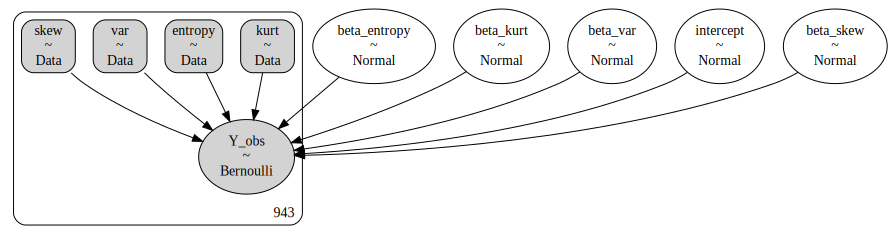

In [26]:
pm.model_to_graphviz(logit_model, formatting = 'plain')

In [27]:
with logit_model:
    display(az.summary(logit_trace, round_to=3, hdi_prob=0.95)[["mean", "hdi_2.5%", "hdi_97.5%"]])

,mean,hdi_2.5%,hdi_97.5%
intercept,14.179,5.990,26.222
beta_var,-12.115,-23.215,-4.963
beta_skew,-8.032,-14.902,-3.503
beta_kurt,-9.278,-17.448,-4.078
beta_entropy,-1.803,-4.175,0.016


In [28]:
with logit_model:
    print (az.summary(logit_trace, round_to=3, hdi_prob=0.95)[["mean", "hdi_2.5%", "hdi_97.5%"]])

                mean  hdi_2.5%  hdi_97.5%
intercept     14.179     5.990     26.222
beta_var     -12.115   -23.215     -4.963
beta_skew     -8.032   -14.902     -3.503
beta_kurt     -9.278   -17.448     -4.078
beta_entropy  -1.803    -4.175      0.016


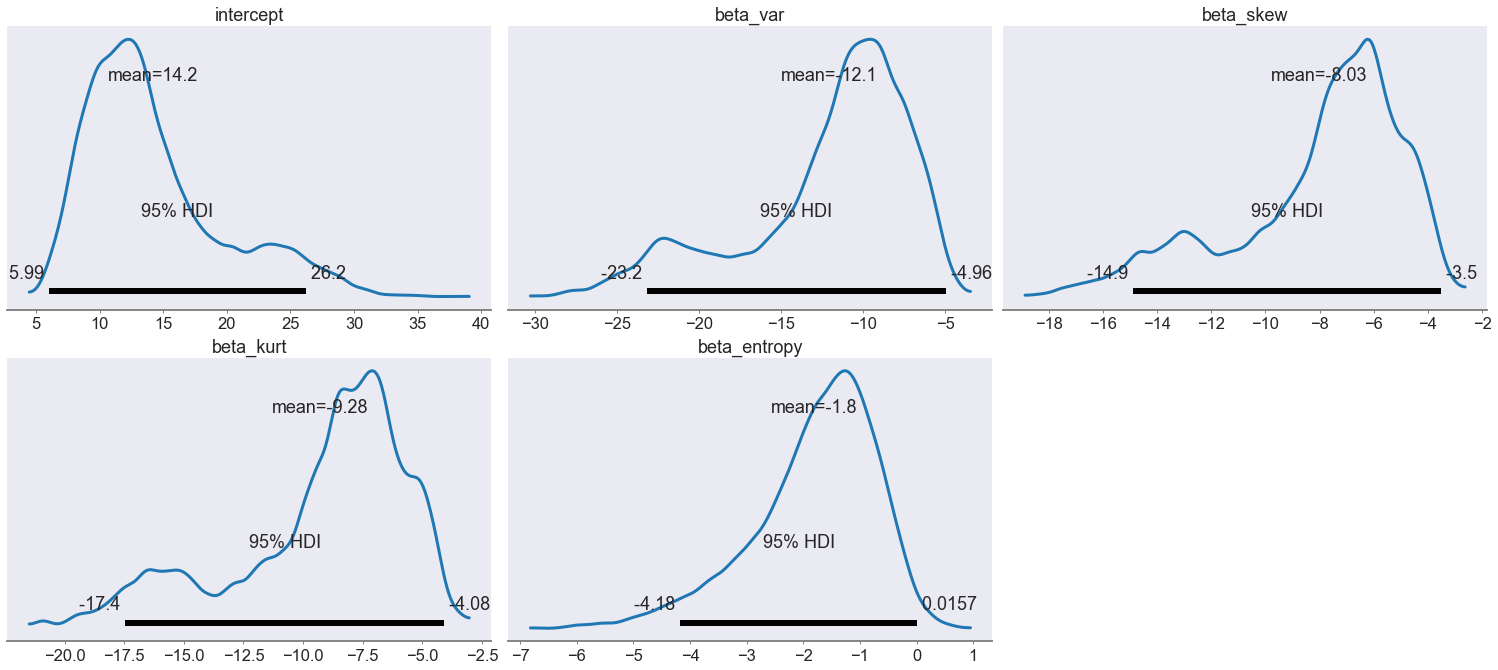

In [29]:
pm.plot_posterior(logit_trace, round_to=3, lw=3, hdi_prob=0.95)
plt.savefig('plots/posterior.png')

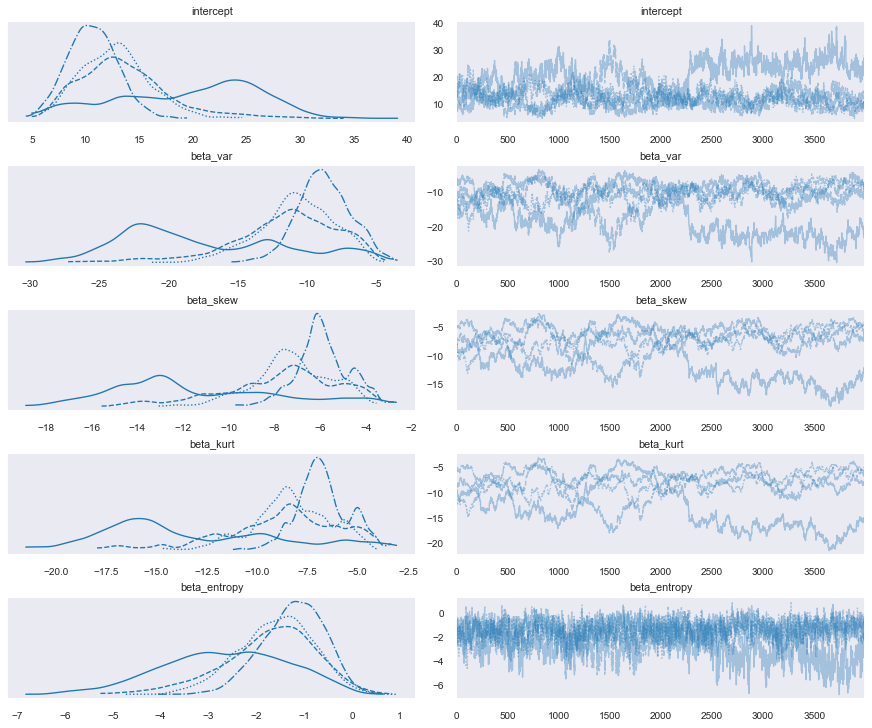

In [30]:
pm.traceplot(logit_trace)
plt.savefig('plots/posterior_dist.png')
plt.show()

In [31]:
beta_inter_post = logit_trace.get_values('intercept')
beta_var_post = logit_trace.get_values('beta_var')
beta_skew_post = logit_trace.get_values('beta_skew')
beta_kurt_post = logit_trace.get_values('beta_kurt')
beta_entropy_post = logit_trace.get_values('beta_entropy')

beta_inter_est = np.round(beta_inter_post.mean(),3)
beta_var_est = np.round(beta_var_post.mean(),3)
beta_skew_est = np.round(beta_skew_post.mean(),3)
beta_kurt_est = np.round(beta_kurt_post.mean(),3)
beta_entropy_est = np.round(beta_entropy_post.mean(),3)

print (f'Bayes Estimators: \nbeta_intercept: {beta_inter_est}, beta_var : {beta_var_est}, beta_skew : {beta_skew_est}, \
beta_kurt : {beta_kurt_est}, beta_entropy : {beta_entropy_est}\n')

model = f'log(p/(1-p)) = {beta_inter_est} + ({beta_var_est}) * variance + ({beta_skew_est}) * skewness +  \
({beta_kurt_est}) * kurtosis + ({beta_entropy_est}) * entropy'
print('Final Equation: \n{}'.format(model))

Bayes Estimators: 
beta_intercept: 14.179, beta_var : -12.115, beta_skew : -8.032, beta_kurt : -9.278, beta_entropy : -1.803

Final Equation: 
log(p/(1-p)) = 14.179 + (-12.115) * variance + (-8.032) * skewness +  (-9.278) * kurtosis + (-1.803) * entropy


In [32]:
# for logit link
deviance_logit = pm.stats.loo(logit_trace, scale='deviance')
deviance_logit = np.round(deviance_logit['loo'],3)
print (f'deviance for logit is {deviance_logit}')

deviance for logit is 38.618


### inference for hold-out set

In [33]:
with logit_model:
    pm.set_data({'var': X_test[:,0]})
    pm.set_data({'skew': X_test[:,1]})
    pm.set_data({'kurt': X_test[:,2]})
    pm.set_data({'entropy': X_test[:,3]})
    posterior = pm.sample_posterior_predictive(logit_trace, random_seed=10)
    
log_odd = posterior['Y_obs']
log_odd.shape, X_test.shape

((16000, 405), (405, 4))

In [34]:
preds_score = log_odd.mean(axis=0)
preds_score.max(), preds_score.min(), preds_score.mean()
preds = np.where(preds_score > 0.5, 1, 0)
accuracy = np.round(np.mean(y_test == preds) * 100, 2)
print (f'accuracy: {accuracy}%')

accuracy: 99.26%


## model evaluation

Confusion matrix


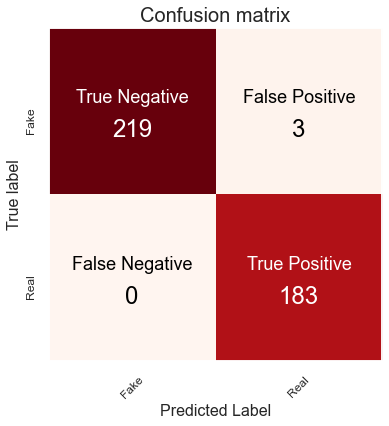

In [36]:
# reference: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def plot_confusion_matrix(cm, classes = ['Fake', 'Real'],
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Display the matrix in text form
    print('Confusion matrix')
#     print(cm)
    plt.figure(figsize=(6, 6))
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i - 0.05, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i + 0.15, format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted Label', size = 16)
    
cm = metrics.confusion_matrix(y_test, preds)
plot_confusion_matrix(cm)
plt.savefig('plots/cnf.png')